In [2]:
import pandas as pd
import glob
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import norm
import json

## 1. Setup the combined CDFs

In [3]:
def merge_csv_files(file_paths):
    """
    This function loads several CSV files and combines them by writing the values for the same columns one below the other in new lines.

    :param file_paths: List of file paths to the CSV files
    :return: Merged DataFrame
    """
    dataframes = [pd.read_csv(file) for file in file_paths]
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

file_paths = ["data/saved_csv/CDF_Functions_Radiation.csv",
              "data/saved_csv/CDF_Functions_Temperature.csv",
              "data/saved_csv/CDF_Functions_Consumption.csv"]
merged_df = merge_csv_files(file_paths)

merged_df.to_csv("data/saved_csv/CDF_Functions.csv", index=False)


## 2. Read the combined CDFs correctly

``CDF: 589 float values in list``

``Radiation_CDF: df["Month_X_Hour_Y"][0]``

``Temperature_CDF: df["Month_X_Hour_Y"][1]``

``X = 1, ..., 12; Y = 0, ..., 23``

In [4]:
file_path = "data/saved_csv/CDF_Functions.csv"

# Read CSV
df = pd.read_csv(file_path)

# Conversion of CDF columns from strings to lists of floats
for column in df.columns[1:]:  # First column is "CDFs", therefore only from column 1
    df[column] = df[column].apply(lambda x: list(map(float, x.split(";"))) if isinstance(x, str) else [])

## Calculate Correlation

In [ ]:
# Load and preprocess consumption data
df_consumption = pd.read_csv('data/household_power_consumption.txt', sep=';')
df_consumption['time'] = pd.to_datetime(df_consumption['Date'] + ' ' + df_consumption['Time'], format='%d/%m/%Y %H:%M:%S')
df_consumption.drop(columns=['Date', 'Time'], inplace=True)
df_consumption.drop(columns=['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','Global_reactive_power', 'Global_intensity', 'Voltage'], inplace=True)
def to_numeric_or_nan(value):
    try:
        return pd.to_numeric(value)
    except ValueError:
        return np.nan
# Convert values in the 'Global_active_power' column to numeric, non-numeric values become NaN
df_consumption['Global_active_power'] = df_consumption['Global_active_power'].apply(to_numeric_or_nan)
# Drop nan's
df_consumption = df_consumption.dropna(subset=['Global_active_power'])
df_consumption['Global_active_power'] = df_consumption['Global_active_power'].astype(float)
df_consumption = df_consumption.set_index("time")
df_consumption = df_consumption['Global_active_power'].resample('h').sum().reset_index()
df_consumption['Global_active_power'] = df_consumption['Global_active_power']/60

In [13]:
# Load and preprocess sun data
df_solar = pd.read_csv("data/Solar_Timeseries_2005_2023.csv")
# Convert timestamp
df_solar['time'] = pd.to_datetime(df_solar['time'], format='%Y%m%d:%H%M', errors='coerce')
df_solar = df_solar[['time', 'G(i) (Globalstrahlung)', 'T2m (Temperatur)']].dropna()
df_solar = df_solar[['time', 'G(i) (Globalstrahlung)', 'T2m (Temperatur)']]
df_solar = df_solar.set_index("time")
df_solar = df_solar[['G(i) (Globalstrahlung)', 'T2m (Temperatur)']].resample('h').mean().reset_index()

In [8]:
# Merge the DataFrames using the time column
merged_df = pd.merge(df_consumption, df_solar, on='time')
merged_df = merged_df.dropna()
merged_df

,time,Global_active_power,G(i) (Globalstrahlung),T2m (Temperatur)
0,2006-12-16 17:00:00,2.533733,0.0,6.64
1,2006-12-16 18:00:00,3.632200,0.0,6.11
2,2006-12-16 19:00:00,3.400233,0.0,5.81
3,2006-12-16 20:00:00,3.268567,0.0,5.61
4,2006-12-16 21:00:00,3.056467,0.0,5.26
...,...,...,...,...
34584,2010-11-26 17:00:00,1.725900,0.0,-0.68
34585,2010-11-26 18:00:00,1.573467,0.0,-0.44
34586,2010-11-26 19:00:00,1.659333,0.0,-0.76
34587,2010-11-26 20:00:00,1.163700,0.0,-2.04


In [16]:
correlation = merged_df[['G(i) (Globalstrahlung)', 'T2m (Temperatur)', 'Global_active_power']].corr()

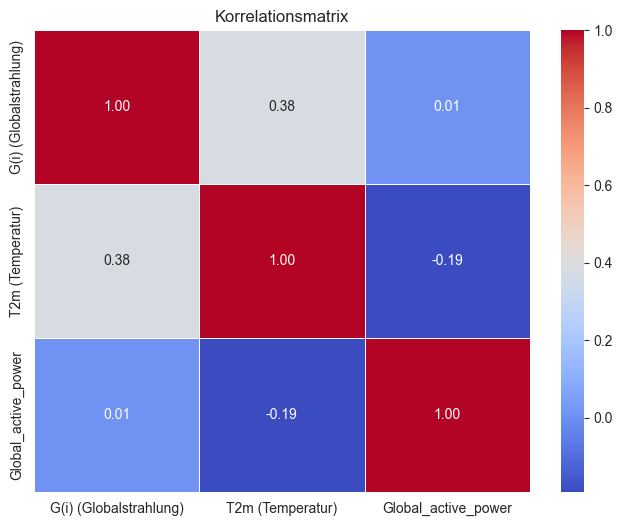

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap für die Korrelationen
plt.figure(figsize=(8,6))
sns.heatmap(merged_df[['G(i) (Globalstrahlung)', 'T2m (Temperatur)', 'Global_active_power']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Korrelationsmatrix")
plt.show()


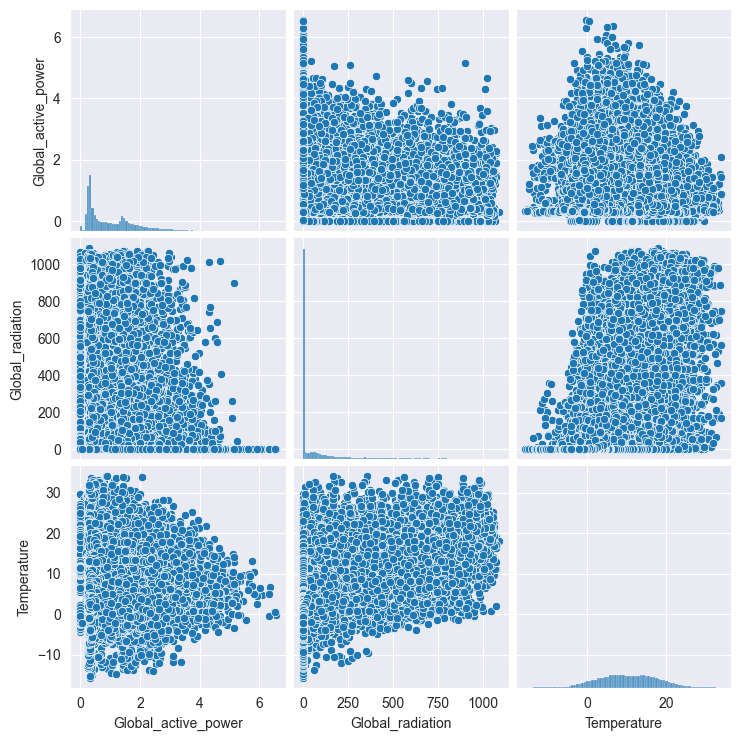

In [17]:
# rename G(i) (Globalstrahlung) to Global_radiation and T2m (Temperatur) to Temperature
sns.pairplot(merged_df.rename(columns={'G(i) (Globalstrahlung)': 'Global_radiation', 'T2m (Temperatur)': 'Temperature'}))
plt.show()


In [18]:
correlation = np.array(correlation)
correlation

array([[ 1.        ,  0.38039259,  0.0071077 ],
       [ 0.38039259,  1.        , -0.192351  ],
       [ 0.0071077 , -0.192351  ,  1.        ]])

In [19]:
def generate_correlated_samples(n_samples, correlation, radiation_cdf, temperature_cdf, active_power_cdf=None):
    """
    Generates n_samples samples that are correlated using Gaussian Copula,
    that the marginal distributions correspond to the specified CDFs (as quantiles).

    Parameters
    ----------
    n_samples : int
        Number of samples to be generated.
    correlation : float
        Desired correlation value between global radiation and temperature.
    radiation_cdf : list or np.array
        Sorted list of values of the radiation distribution (589 values).
    temperature_cdf : list or np.array
        Sorted list of temperature distribution values (589 values).
    active_power_cdf : list or np.array, optional
        Sorted list of values of the active_power distribution (589 values). Default: None.

    Returns
    -------
    radiation_samples : np.array
        Samples from the radiation distribution.
    temperature_samples : np.array
        Samples from the temperature distribution.
    active_power_samples : np.array
        Samples from the active_power distribution (if active_power_cdf is specified).
    """
    # Covariance matrix for 3 variables (if active_power_cdf is specified)
    if active_power_cdf is not None:
        cov = correlation
    else:
        cov = np.array([[1, correlation],
                        [correlation, 1]])

    # Generate samples from the multivariate normal distribution
    mv_samples = np.random.multivariate_normal(mean=[0]*cov.shape[0], cov=cov, size=n_samples)

    # Transformation into uniform variables via the standard normal CDF
    u = norm.cdf(mv_samples)

    # Create equidistant probabilities that correspond to the quantiles of the CDFs
    p_radiation = np.linspace(0, 1, len(radiation_cdf))
    p_temperature = np.linspace(0, 1, len(temperature_cdf))

    # Inverse Transform Sampling by means of interpolation
    radiation_samples = np.interp(u[:, 0], p_radiation, radiation_cdf)
    temperature_samples = np.interp(u[:, 1], p_temperature, temperature_cdf)

    if active_power_cdf is not None:
        p_active_power = np.linspace(0, 1, len(active_power_cdf))
        active_power_samples = np.interp(u[:, 2], p_active_power, active_power_cdf)
        return radiation_samples, temperature_samples, active_power_samples

    return radiation_samples, temperature_samples

def generate_samples_for_hour_from_df(df, column, n_samples=1000, correlation=0.3786):
    """
    Generates correlated samples for the specified hour (column) from the
    already loaded DataFrame.

    Assumptions:
      - The DataFrame contains columns with names such as "Month_X_Hour_Y"
        (X = 1, ..., 12; Y = 0, ..., 23).
      - In each of these columns:
            Row 0 contains the Radiation_CDF (list of 589 floats)
            Row 1 contains the Temperature_CDF (list of 589 floats)
            Row 2 contains the active_power_CDF (list of 589 floats) (optional)

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame that contains the CDFs.
    column : str
        Name of the column, e.g. "Month_4_Hour_13".
    n_samples : int, optional
        Number of samples to be generated (default: 1000).
    correlation : float, optional
        Desired correlation value (default: 0.3786).

    Returns
    -------
    radiation_samples, temperature_samples, active_power_samples : tuple of np.array
        Correlated samples from the radiation, temperature and active_power distribution.
    """
    radiation_cdf = df[column][0]
    temperature_cdf = df[column][1]
    active_power_cdf = df[column][2] if len(df[column]) > 2 else None

    return generate_correlated_samples(n_samples, correlation, radiation_cdf, temperature_cdf, active_power_cdf)


In [20]:
def cluster_scenarios_with_probabilities(column, correlation, n_samples=1000, n_clusters=5):
    """
    Groups scenarios based on the specified column values and calculates their probabilities.

    Parameters
    ----------
    column : str
        The name of the column used to generate samples. Format: Month_{month}_Hour_{hour}
    correlation : float
        The correlation used to generate samples (calculated at the beginning of the document).
    n_samples : int, optional
        The number of samples to be generated. Default is 1000 as used by us.
    n_clusters : int, optional
        The number of clusters for the KMeans algorithm. Default is 5 as used by us.

    Returns
    -------
    tuple
        A tuple with two lists:
        - scenarios : List[List[float]]
            The cluster centers that represent the scenarios.
        - probabilities : List[float]
            The probabilities of each cluster/scenario.
    """

    samples_rad, samples_temp, samples_active_power = generate_samples_for_hour_from_df(df, column, n_samples=n_samples, correlation=correlation)
    samples = np.vstack((samples_rad, samples_temp, samples_active_power)).T

    # Create a KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Adapt the model to the data
    kmeans.fit(samples)

    # Assignment of the clusters
    labels = kmeans.labels_

    # Show cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Calculate probabilities (relative frequency of points in each cluster)
    unique, counts = np.unique(labels, return_counts=True)
    probs = counts / len(samples)

    # Save results
    scenarios = cluster_centers.tolist()
    probabilities = probs.tolist()
    return scenarios, probabilities

In [21]:
all_scenarios = []
all_probabilities = []
for month in range(1,13):
    for hour in range(0, 24):
        column = f"Month_{month}_Hour_{hour}"
        scenarios, probabilities = cluster_scenarios_with_probabilities(column, correlation, n_samples=1000, n_clusters=5)
        all_scenarios.append(scenarios)
        all_probabilities.append(probabilities)

## Visualize the results

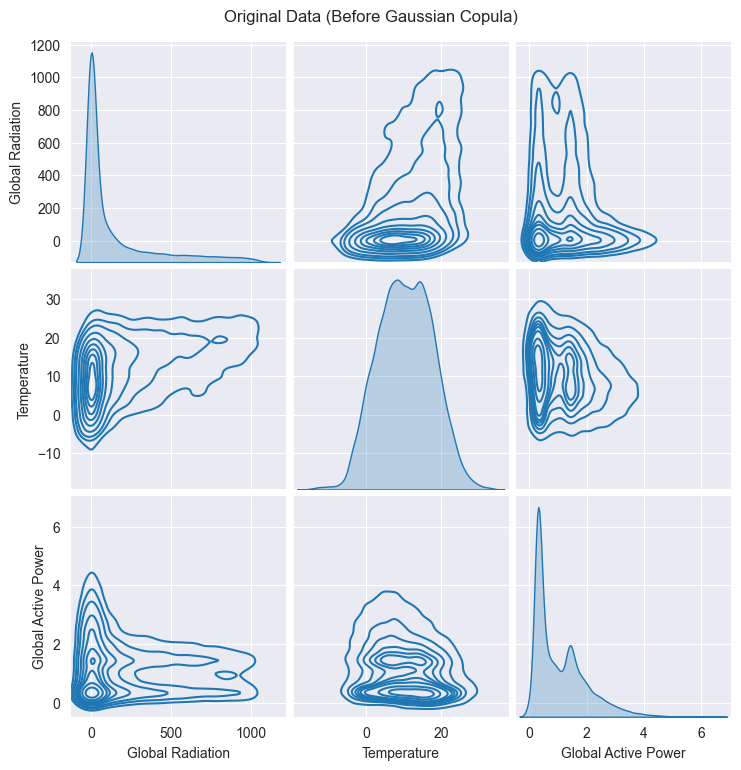

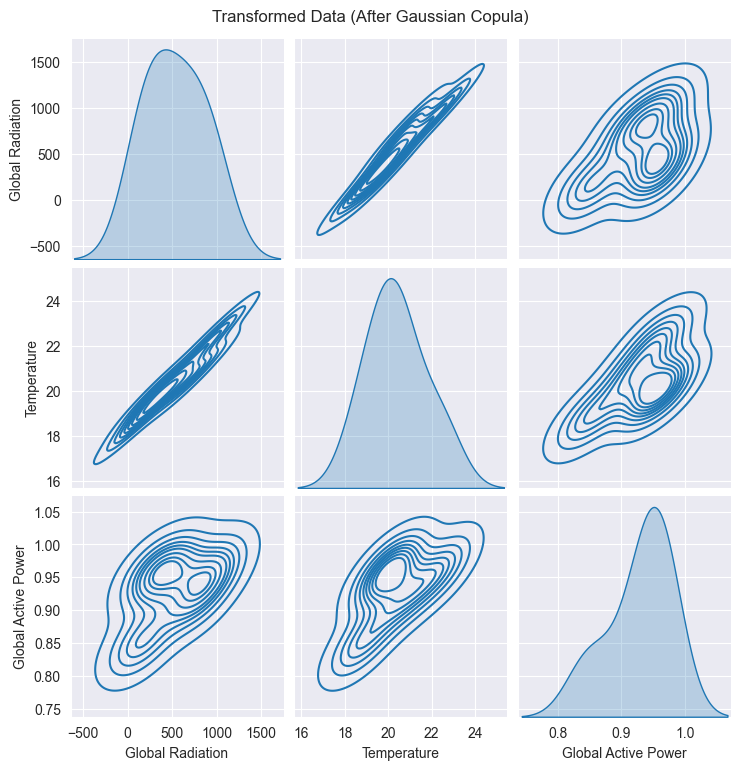

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example: Cluster centers for Month 6, Hour 12 (after Gaussian Copula transformation)
month_idx = 5  # June
hour_idx = 12  # 12 PM
cluster_centers = np.array(all_scenarios[month_idx * 24 + hour_idx])  # Shape: (n_clusters, 3)
df_after = pd.DataFrame(cluster_centers, columns=["Global Radiation", "Temperature", "Global Active Power"])

# Original data before Gaussian Copula (with German column names)
df_before = merged_df[['G(i) (Globalstrahlung)', 'T2m (Temperatur)', 'Global_active_power']]

# Rename German column names to English
df_before.columns = ["Global Radiation", "Temperature", "Global Active Power"]

# First Pairplot (Original Data)
g1 = sns.pairplot(df_before, kind="kde")
g1.fig.suptitle("Original Data (Before Gaussian Copula)", y=1.02)
plt.show()  # Ensures the first plot is fully displayed before the next one

# Second Pairplot (Transformed Data)
g2 = sns.pairplot(df_after, kind="kde")
g2.fig.suptitle("Transformed Data (After Gaussian Copula)", y=1.02)
plt.show()  # Ensures the second plot is fully displayed


### Data Comparison: Before vs. After Gaussian Copula

#### Original Data (Before Gaussian Copula)
- **Skewed distributions:**
  - Global Radiation is heavily right-skewed.
  - Global Active Power has multiple peaks.
  - Temperature is nearly normal.
- **Non-linear dependencies:**
  - Curved relationships between variables.
  - Distinct clusters in Active Power.

#### Transformed Data (After Gaussian Copula)
- **Marginal distributions appear normal** (bell-shaped curves).
- **Stronger linear relationships** (especially Radiation & Temperature).
- **Smoother dependencies** but still visible structure.

#### Key Takeaways
- Gaussian Copula makes variables more Gaussian-like.
- Non-linearities are reduced, making data better for modeling.
- Cluster structures remain, preserving key dependencies.

In [ ]:
# Save results in JSON files
with open('data/results/all_scenarios.json', 'w') as f:
    json.dump(all_scenarios, f)

with open('data/results/all_probabilities.json', 'w') as f:
    json.dump(all_probabilities, f)